In [1]:
# --- Sanity check for model paths & loadability (run this first) ---
import os, sys, hashlib, math
from pathlib import Path

repo = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
print("CWD:", repo)

# Expected locations (relative to the notebook/repo root)
frame_ckpt = repo / "models" / "frame_synthesis.pth"
unet_dir   = repo / "models" / "unet"
unet_cfg   = unet_dir / "config.json"
unet_wt    = unet_dir / "diffusion_pytorch_model.safetensors"

def human(n): 
    for u in ["B","KB","MB","GB","TB"]:
        if n < 1024: return f"{n:.2f} {u}"
        n /= 1024
    return f"{n:.2f} PB"

# 1) Existence checks
print("\n[Existence]")
print("frame_synthesis.pth:", frame_ckpt.exists(), frame_ckpt)
print("unet/ folder       :", unet_dir.exists(), unet_dir)
print("config.json        :", unet_cfg.exists(), unet_cfg)
print("safetensors        :", unet_wt.exists(), unet_wt)

# 2) Size checks
if frame_ckpt.exists(): print("frame_synthesis.pth size:", human(frame_ckpt.stat().st_size))
if unet_wt.exists():    print("UNet weights size        :", human(unet_wt.stat().st_size))

# 3) Try to load on CPU (no GPU required)
import torch
device = torch.device("cpu")
print("\n[PyTorch]", torch.__version__, "device:", device)

# Try loading the frame-synthesis checkpoint dict
try:
    ckpt = torch.load(frame_ckpt, map_location=device)
    # ckpt can be either a full model or state_dict; we just ensure it's readable:
    if isinstance(ckpt, dict):
        print("Loaded frame_synthesis.pth (dict keys):", list(ckpt.keys())[:5], "...")
    else:
        print("Loaded frame_synthesis.pth (object type):", type(ckpt))
    del ckpt
    print("✅ frame_synthesis.pth is readable.")
except Exception as e:
    print("❌ Failed to load frame_synthesis.pth:", repr(e))

# Try loading UNet via diffusers (if this repo uses diffusers-style UNet)
try:
    from diffusers import UNet2DConditionModel
    unet = UNet2DConditionModel.from_pretrained(unet_dir.as_posix())
    print("✅ UNet loaded via diffusers:", type(unet))
    del unet
except Exception as e:
    print("⚠️ Could not load UNet via diffusers:", repr(e))
    print("   If this repo uses a custom UNet class, it may be loaded elsewhere in the notebook.")

CWD: c:\Users\ritwi\generative-image-dynamics

[Existence]
frame_synthesis.pth: True c:\Users\ritwi\generative-image-dynamics\models\frame_synthesis.pth
unet/ folder       : True c:\Users\ritwi\generative-image-dynamics\models\unet
config.json        : True c:\Users\ritwi\generative-image-dynamics\models\unet\config.json
safetensors        : True c:\Users\ritwi\generative-image-dynamics\models\unet\diffusion_pytorch_model.safetensors
frame_synthesis.pth size: 38.27 MB
UNet weights size        : 1.02 GB

[PyTorch] 2.5.1+cu121 device: cpu
Loaded frame_synthesis.pth (dict keys): ['losses', 'model', 'optimizer'] ...
✅ frame_synthesis.pth is readable.


C:\Users\ritwi\AppData\Local\Temp\ipykernel_11824\2789993773.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(frame_ckpt, map_location=device)
Some wei

✅ UNet loaded via diffusers: <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>


In [2]:
import traceback, sys
print("Using Python:", sys.executable)

try:
    import moviepy
    print("moviepy version:", moviepy.__version__, "->", moviepy.__file__)
    from moviepy import editor as mpy
    print("Imported moviepy.editor OK")
except Exception as e:
    print("❌ moviepy.editor import failed:\n")
    traceback.print_exc()


Using Python: c:\Users\ritwi\Miniconda3\envs\gid\python.exe
moviepy version: 1.0.3 -> c:\Users\ritwi\Miniconda3\envs\gid\lib\site-packages\moviepy\__init__.py
Imported moviepy.editor OK


# Generate optical flow from an image

In [3]:
import os
import datetime
from diffusers import UNet2DModel, DDPMScheduler
from models.motion_synthesis import VQModel_, generate_spectrum
from utils import *

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

ROOT = Path.cwd()

transforms = FrameSpectrumProcessing(num_freq=16)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195, beta_schedule="scaled_linear")
vae = VQModel_.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae").to(DEVICE).eval()
# unet = UNet2DModel.from_pretrained("data/models/unet").to(DEVICE).eval()

# === UNet: load your local checkpoint ===
# NOTE: your weights live at ./models/unet
unet_path = (ROOT / "models" / "unet").as_posix()
unet = UNet2DModel.from_pretrained(
    unet_path,
    low_cpu_mem_usage=True,         # faster/lower RAM if 'accelerate' is installed
    use_safetensors=True,
    ignore_mismatched_sizes=True    # tolerate small layout diffs
).to(DEVICE).eval()

out_dir = ROOT / "data" / "unet_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
print(f"Saving UNet samples to: {out_dir}")

An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Saving UNet samples to: c:\Users\ritwi\generative-image-dynamics\data\unet_samples


In [4]:
# Load an image
image_path = "data/images/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg"
frame_np = get_image(image_path, width=256, height=160, crop=True)
frame = transforms.process_frame(frame_np).unsqueeze(0).to(DEVICE)

# Generate motion spectrum
num_steps = 100

sample_name = "_".join([
    os.path.split(image_path)[1],
    "ddpm" + str(num_steps),
    datetime.datetime.now().isoformat().replace(":", "_")
])

spec_np = generate_spectrum(vae, unet, noise_scheduler, frame, num_steps=num_steps, batch_size=1)

path = os.path.join(out_dir, sample_name + ".npy")
save_npy(spec_np, path)
print(f"sample saved at {path}")

# Visualize the result
spec_image, video = visualize_sample(frame_np, spec_np, transforms, magnification=5.0, include_flow=True)

path = os.path.join(out_dir, sample_name + ".png")
spec_image.save(path)
print(f"spectrum image saved at {path}")

path = os.path.join(out_dir, sample_name + ".mp4")
video.write_videofile(path, logger=None)
print(f"video saved at {path}")

100%|██████████| 16/16 [02:13<00:00,  8.37s/it]


sample saved at c:\Users\ritwi\generative-image-dynamics\data\unet_samples\512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-11-17T18_15_44.753293.npy
spectrum image saved at c:\Users\ritwi\generative-image-dynamics\data\unet_samples\512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-11-17T18_15_44.753293.png
video saved at c:\Users\ritwi\generative-image-dynamics\data\unet_samples\512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-11-17T18_15_44.753293.mp4


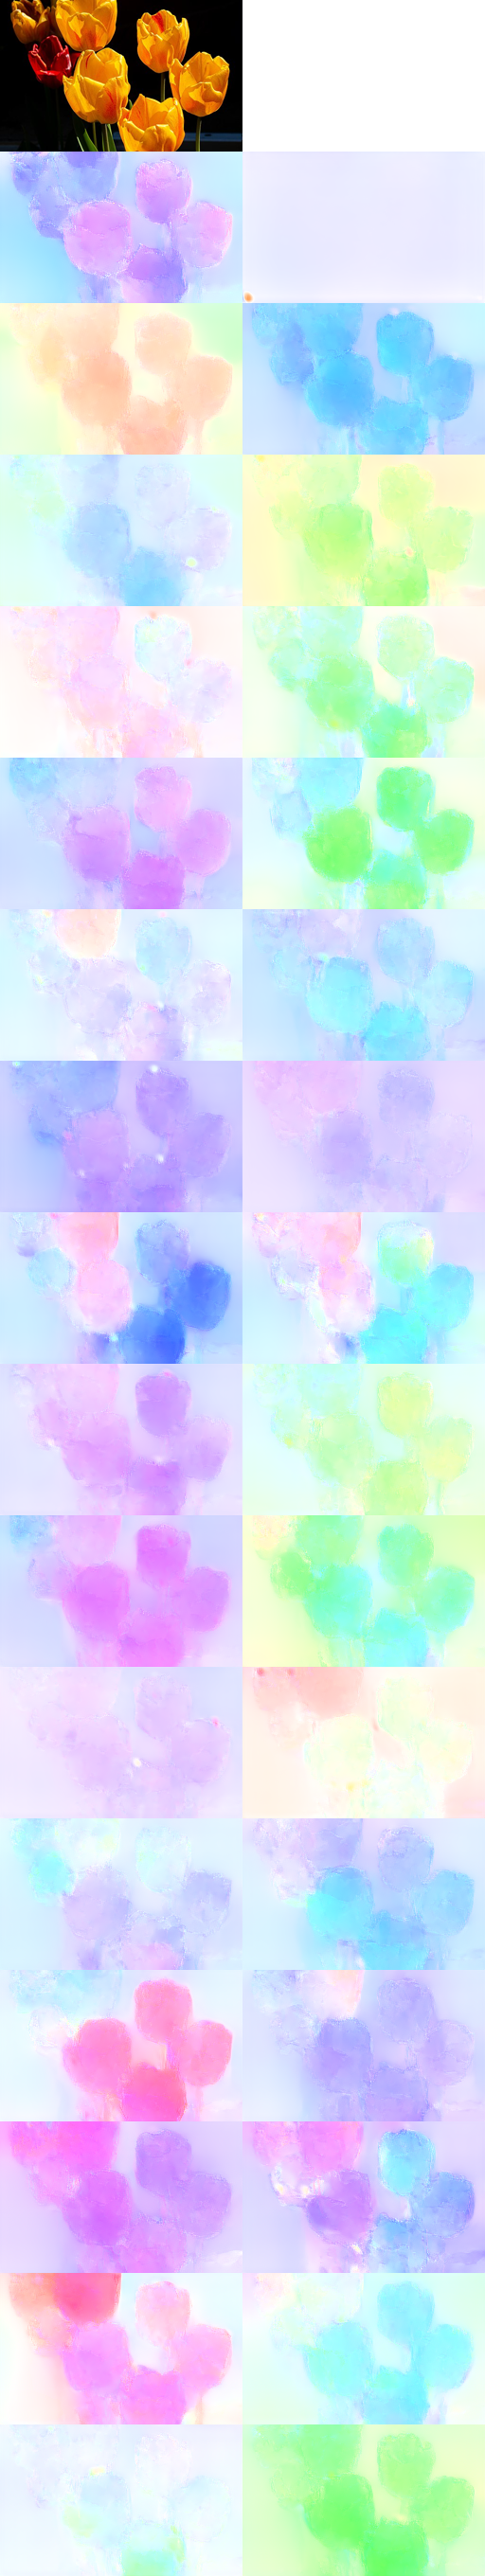

In [5]:
# Show generated FFT in an image. Each row shows a frequency with the real part on the left and the imaginary part on the right.
spec_image

In [6]:
# Show optical flow derived from generated spectrum and warped frames
video.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

# Generate video from image and optical flow

In [7]:
import cupy as cp, torch
print("CuPy:", cp.__version__)
print("CUDA devices:", cp.cuda.runtime.getDeviceCount())
print("GPU name:", cp.cuda.runtime.getDeviceProperties(0)['name'].decode())
print("Torch CUDA available:", torch.cuda.is_available())

CuPy: 13.6.0
CUDA devices: 1
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Torch CUDA available: True


In [8]:
import numpy as np
print("NumPy in notebook:", np.__version__)

import sys
sys.path.insert(0, r"C:\Users\ritwi\pyflow")

import pyflow
print("pyflow loaded from:", pyflow.__file__)


NumPy in notebook: 1.24.4
pyflow loaded from: C:\Users\ritwi\pyflow\pyflow.cp310-win_amd64.pyd


In [9]:
import datetime
import moviepy.editor as mpy
from models.frame_synthesis import *
from utils import *
from utils.flow import optical_flow
DEVICE = torch.device("cuda:0")

model = Synthesis()
model.load_state_dict(torch.load("models/frame_synthesis.pth")["model"])
model = model.to(DEVICE).eval()

transforms = FrameFlowProcessing()

In [10]:
# Load a 5-second frame sequence
video_path = "data/videos/Fleur_de_pommier_18.mp4"
start_sec = 5
fps = 30
num_frames = 150

frames = get_frames(video_path, w=256, h=160, start_sec=start_sec, fps=fps, f=num_frames)

# Show the sequence
clip = mpy.ImageSequenceClip(list(frames), fps=fps)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [11]:
# Estimate optical flow from the first frame to each frame
start_time = datetime.datetime.now()
flow = optical_flow(frames[0], frames[1:])
print(datetime.datetime.now() - start_time)

0:01:27.271889


In [12]:
# Visualize optical flow
flow_color = flow_to_color_video(flow)

clip = mpy.ImageSequenceClip(list(flow_color), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [13]:
# Reconstruct the video from the first frame and optical flow
print(type(flow))
print(flow.shape)

src_frame = transforms.process_frame(frames[0]).unsqueeze(0).to(DEVICE).float()
flow = transforms.process_flow(flow).to(DEVICE).float()
pred = predict_tensor(src_frame, flow, model, transforms, return_tensor=False)

clip = mpy.ImageSequenceClip(list(np.concatenate([
    add_video_title(frames[1:], "Original frames"),
    add_video_title(pred, "Model prediction")
], axis=2)), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

<class 'numpy.ndarray'>
(149, 160, 256, 2)
